In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import re
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
!pip install -U spacy
!python -m spacy download fr_dep_news_trf #here model selected is french with target of accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.8/397.8 MB 1.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_dep_news_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import spacy as sp

# Load the French language model
nlp = sp.load('fr_dep_news_trf')

In [4]:
sample_submission = pd.read_csv("https://raw.githubusercontent.com/JohannG3/DS_ML/main/sample_submission.csv")
training_data = pd.read_csv("https://raw.githubusercontent.com/JohannG3/DS_ML/main/training_data.csv", encoding='utf-8')
unlabelled_test_data = pd.read_csv("https://raw.githubusercontent.com/JohannG3/DS_ML/main/unlabelled_test_data.csv", encoding='utf-8')

In [5]:
training_data['difficulty'].value_counts()

difficulty
A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: count, dtype: int64

In [6]:
sample_submission.head()

,id,difficulty
0,0,A1
1,1,A1
2,2,A1
3,3,A1
4,4,A1


In [7]:
training_data.head()

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1


In [8]:
training_data['difficulty'].unique()

array(['C1', 'A1', 'B1', 'A2', 'B2', 'C2'], dtype=object)

In [9]:
unlabelled_test_data.head()

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."


### 1.2 Decision Tree classifier

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [11]:
"""
#an alternative way to split the dataset
!pip install fast_ml --quiet
from fast_ml.model_development import train_valid_test_split
"""

'\n#an alternative way to split the dataset\n!pip install fast_ml --quiet\nfrom fast_ml.model_development import train_valid_test_split\n'

In [12]:
def preprocess_text(text):
    doc = nlp(text)
    # Lemmatization and tokenization
    preprocessed_tokens = [token.lemma_ for token in doc if not token.is_punct]
    return ' '.join(preprocessed_tokens)  # Join tokens back into a sentence

# Preprocess the sentences
training_data['preprocessed_text'] = training_data['sentence'].apply(preprocess_text)

# Label encoding
label_map = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
training_data['encoded_difficulty'] = training_data['difficulty'].map(label_map)


In [13]:
# Split data into features and labels
X= training_data['preprocessed_text']
y= training_data['encoded_difficulty']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [15]:
# Create a pipeline with TfidfVectorizer and KNeighborsClassifier
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('decision_tree', DecisionTreeClassifier())
])

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('decision_tree', DecisionTreeClassifier())])

In [16]:
y_pred = pipe.predict(X_test)

In [ ]:
len(y_pred)

In [ ]:
len(y_test)

In [17]:
# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.55      0.49       166
           1       0.25      0.27      0.26       158
           2       0.25      0.24      0.24       166
           3       0.21      0.21      0.21       153
           4       0.31      0.29      0.30       152
           5       0.29      0.22      0.25       165

    accuracy                           0.30       960
   macro avg       0.29      0.30      0.29       960
weighted avg       0.29      0.30      0.29       960



In [18]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.2989583333333333


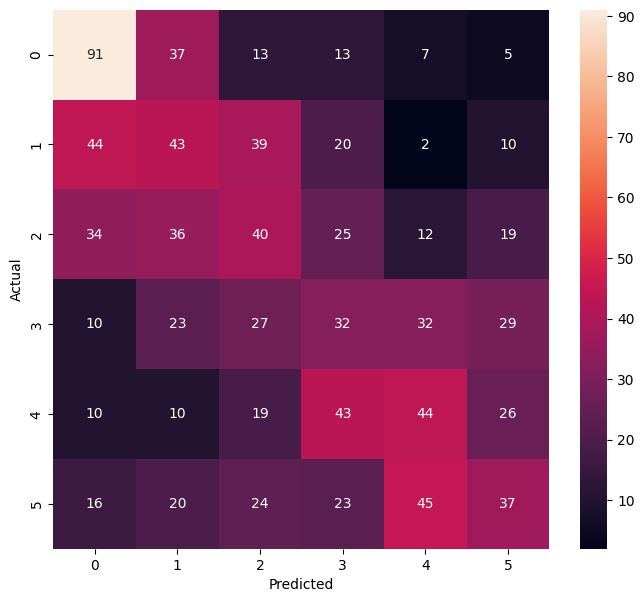

In [19]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Grid Search optimisation

In [25]:
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [26]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create a pipeline with TfidfVectorizer and RandomForestClassifier
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the parameter grid
param_distributions = {
    'tfidf__max_df': uniform(0.75, 0.25),
    'tfidf__min_df': randint(1, 6),
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': randint(2, 11),
    'classifier__min_samples_leaf': randint(1, 5)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipe, param_distributions, n_iter=50, cv=3, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit the random search to the training data
random_search.fit(X_train_split, y_train_split)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

# Evaluate on validation set
best_model = random_search.best_estimator_
val_accuracy = best_model.score(X_val, y_val)
print("Validation set accuracy: ", val_accuracy)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:  {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 141, 'tfidf__max_df': 0.8390744595192438, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Best cross-validation score:  0.3899739583333333
Validation set accuracy:  0.4010416666666667


In [27]:
# Use the best model to make predictions on the validation set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)

# Decode the predicted labels back to their original difficulty levels
reverse_label_map = {v: k for k, v in label_map.items()}
y_pred_original = [reverse_label_map[label] for label in y_pred]

# Evaluate the model
print("Classification Report:\n", classification_report(y_val, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.73      0.53       122
           1       0.44      0.31      0.37       138
           2       0.36      0.24      0.29       129
           3       0.37      0.30      0.33       128
           4       0.37      0.41      0.39       128
           5       0.43      0.43      0.43       123

    accuracy                           0.40       768
   macro avg       0.40      0.41      0.39       768
weighted avg       0.40      0.40      0.39       768



In [28]:
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4010416666666667


In [1]:
y_val_array = y_val.to_numpy()

NameError: name 'y_val' is not defined

In [32]:
df_y_val = pd.DataFrame(y_val_array, columns=['Actual'])
df_y_pred = pd.DataFrame(y_pred, columns=['Predicted'])

df_y_val.to_csv('DT_y_val.csv', index=False)
df_y_pred.to_csv('DT_y_pred.csv', index=False)

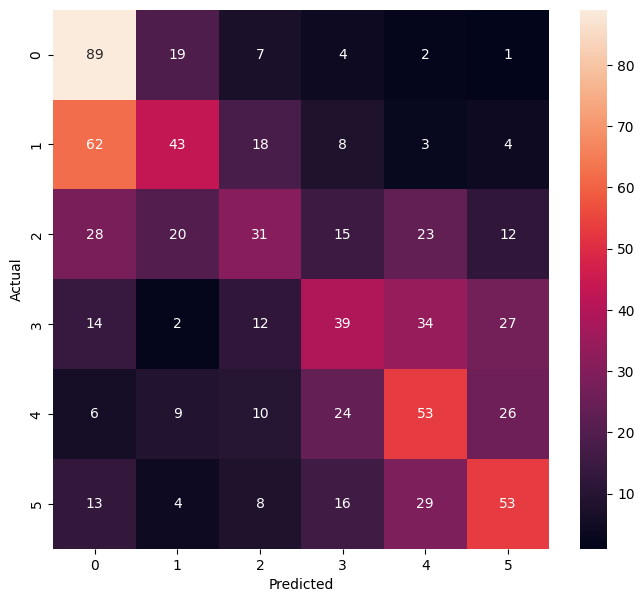

In [33]:
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Label submission

In [ ]:
unlabelled_test_data['preprocessed_text'] = unlabelled_test_data['sentence'].apply(preprocess_text)

# Predict the difficulty levels
X_test_obj = unlabelled_test_data['preprocessed_text']
y_pred_obj = best_model.predict(X_test_obj)

In [ ]:
y_pred_obj

array([3, 1, 1, ..., 3, 0, 0])

In [ ]:
reverse_label_map = {v: k for k, v in label_map.items()}

# Convert the predicted encoded labels back to their original labels
y_pred_original = [reverse_label_map[encoded_label] for encoded_label in y_pred_obj]


In [ ]:
sample_submission['predicted difficulty'] = y_pred_original

In [ ]:
sample_submission_fin = sample_submission.drop('difficulty', axis=1)
sample_submission_fin.head()

,id,predicted difficulty
0,0,B2
1,1,A2
2,2,A2
3,3,A1
4,4,C2
